# Sensitivity Analysis for ABS

Author: A.Pilko <a.pilko@soton.ac.uk>

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
from pyDOE2 import *
import subprocess
import joblib as jl

### Parameters


In [114]:
## Constants
BOUNDS = '-145176.17270300398,-101964.24515822314,6569893.199178016,6595219.236650961,0,1524'
PROJ_PATH = '/home/aliaksei/PycharmProjects/sandbox/abs_tester/'
OWNPATH_PATH = PROJ_PATH + 'test_data/path.csv'
OWNPATH_PATH_LENGTH = 68818.61266545641
ALTS_PATH = PROJ_PATH + 'test_data/alts.csv'
TRACKS_PATH = PROJ_PATH + 'test_data/tracks.csv'
VELS_PATH = PROJ_PATH + 'test_data/vels.csv'
VERTS_PATH = PROJ_PATH + 'test_data/vert_rates.csv'

BINARY_NAME = '/home/aliaksei/GoProjects/abs-specific/abs-specific'
cmd_args = [BINARY_NAME, '--bounds', BOUNDS, '--simOps', '100000', '--altDataPath', ALTS_PATH,'--velDataPath', VELS_PATH, '--trackDataPath', TRACKS_PATH, '--vertRateDataPath', VERTS_PATH, '--ownPath', OWNPATH_PATH]

RESULT_DIR = PROJ_PATH + 'results'

### Design of Experiments

In [115]:
traffic_density_levels = [5e-10, 1e-10, 5e-12]
timestep_levels = [2, 0.5, 1]
surface_entrance_levels = [0,1]

design_matrix = fullfact([len(traffic_density_levels), len(timestep_levels), len(surface_entrance_levels)])
def fill_dm(row):
    return traffic_density_levels[int(row[0])], timestep_levels[int(row[1])], surface_entrance_levels[int(row[2])]
design_matrix = np.apply_along_axis(fill_dm, 1, design_matrix)
design_matrix

array([[5.e-10, 2.e+00, 0.e+00],
       [1.e-10, 2.e+00, 0.e+00],
       [5.e-12, 2.e+00, 0.e+00],
       [5.e-10, 5.e-01, 0.e+00],
       [1.e-10, 5.e-01, 0.e+00],
       [5.e-12, 5.e-01, 0.e+00],
       [5.e-10, 1.e+00, 0.e+00],
       [1.e-10, 1.e+00, 0.e+00],
       [5.e-12, 1.e+00, 0.e+00],
       [5.e-10, 2.e+00, 1.e+00],
       [1.e-10, 2.e+00, 1.e+00],
       [5.e-12, 2.e+00, 1.e+00],
       [5.e-10, 5.e-01, 1.e+00],
       [1.e-10, 5.e-01, 1.e+00],
       [5.e-12, 5.e-01, 1.e+00],
       [5.e-10, 1.e+00, 1.e+00],
       [1.e-10, 1.e+00, 1.e+00],
       [5.e-12, 1.e+00, 1.e+00]])

In [116]:
def run(traffic_density, timestep, surface_entrance):
    output_db_name = f'{RESULT_DIR}/out_{traffic_density:.1e}_{timestep:.1e}_{bool(surface_entrance)}.db'
    # print(' '.join(cmd_args + ['--db-path', output_db_name,'--target-density', str(traffic_density), '--timestep', str(timestep)]))
    os.system(' '.join(cmd_args + ['--dbPath', output_db_name,'--target-density', str(traffic_density), '--timestep', str(timestep), '--surfaceEntrance', str(bool(surface_entrance)).lower()]))

# for row in design_matrix:
#     run(*row)

In [117]:
jl.Parallel(n_jobs=-1, verbose=10)(jl.delayed(run)(*row) for row in design_matrix)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Created/Opened output database
Running 16 batches of 6250 simulations
Simulating 27308.97327994302 hrs, with 0.2730897327994302 hrs per simulation
Created/Opened output database
Created/Opened output database
Running 16 batches of 6250 simulations
Running 16 batches of 6250 simulations
Simulating 27308.97327994302 hrs, with 0.2730897327994302 hrs per simulation
Simulating 27308.97327994302 hrs, with 0.2730897327994302 hrs per simulation
Created/Opened output database
Running 16 batches of 6250 simulations
Simulating 27308.97327994302 hrs, with 0.2730897327994302 hrs per simulation
Created/Opened output database
Running 16 batches of 6250 simulations
Simulating 27308.97327994302 hrs, with 0.2730897327994302 hrs per simulation
Created/Opened output database
Running 16 batches of 6250 simulations
Simulating 27308.97327994302 hrs, with 0.2730897327994302 hrs per simulation
Created/Opened output database
Running 16 batches of 6250 simulations
Simulating 27308.97327994302 hrs, with 0.2730897

[Parallel(n_jobs=-1)]: Done   6 out of  18 | elapsed:  4.3min remaining:  8.5min


Formatting 100000 results for database insertion
Inserting results into database
Completed successfully in 605.235702603 seconds.
 6.052357026030001e-06 ms per simulation.
 0.022162521322158724 secs per simulated hour.
Exiting...
Formatting 100000 results for database insertion
Inserting results into database
Completed successfully in 609.988335075 seconds.
 6.09988335075e-06 ms per simulation.
 0.02233655322087864 secs per simulated hour.
Exiting...
Formatting 100000 results for database insertion
Inserting results into database
Completed successfully in 1069.348298906 seconds.
 1.069348298906e-05 ms per simulation.
 0.03915739665289354 secs per simulated hour.
Exiting...
Formatting 100000 results for database insertion
Inserting results into database
Completed successfully in 1029.303301389 seconds.
 1.0293033013889998e-05 ms per simulation.
 0.037691028909716214 secs per simulated hour.
Exiting...



KeyboardInterrupt



In [120]:
import sqlite3
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

results = []

for db in glob(RESULT_DIR+'/**'):
    filename = Path(db).stem
    tokens = filename.split('_')
    traffic_density = float(tokens[1])
    timestep = float(tokens[2])
    surface_entrance = tokens[3] == 'True'

    dbcon = sqlite3.connect(db)
    dbcur = dbcon.cursor()
    res = dbcur.execute("SELECT * FROM sims").fetchall()
    sim_data = np.array(res, dtype=np.longlong)[:, 2:]
    sim_data = np.cumsum(sim_data, axis=0)
    n_sims = sim_data.shape[0]
    n_conflicts = sim_data[-1,1]
    sim_data = np.hstack((sim_data, (sim_data[:, 1] / (sim_data[:, 0]/3600))[:, None]))

    # fig, ax = plt.subplots(
    #     1, 1, figsize=(12,6),
    # )
    #
    # ax.plot(range(sim_data.shape[0]), sim_data[:, 2])
    # ax.axhline(np.median(sim_data[:,2]), color='red', linestyle=':')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_title(f"ABS convergence\nTraffic Density {traffic_density:1e} m$^{-3}$ hr$^{-1}$ \nTimestep {timestep:.1e}s\nSurface Entrance {surface_entrance}")
    # ax.set_xlabel("Operations Simulated")
    # ax.set_ylabel("uMAC Risk/hour")
    # print(f'Traffic Density {traffic_density:1e} m$^{-3}$ hr$^{-1}$ \nTimestep {timestep:.1e}s\nSurface Entrance {surface_entrance} \nMedian uMAC rate {np.median(sim_data[:,2]):2e} per hour\n\n-----------------\n\n')

    conflict_sum = sim_data[:, 2].sum()
    sim_secs = (OWNPATH_PATH_LENGTH/70)*sim_data.shape[0]
    sim_hrs = sim_secs / (60*60)
    # sim_hrs = sim_data[:, 1].sum() / (60*60)
    sim_ops = sim_data.shape[0]
    mean_col_rate = conflict_sum / sim_hrs
    median_col_rate = np.median(sim_data[:,2])
    conv_metric = 1- (np.abs(np.diff(sim_data[-5000:,2]).sum())/median_col_rate)
    results.append([traffic_density, timestep, surface_entrance, sim_hrs, median_col_rate, conv_metric])

['out', '5.0e-12', '2.0e+00', 'False']
['out', '1.0e-13', '3.0e+00', 'False']


/tmp/ipykernel_6619/1143228051.py:46: RuntimeWarning: invalid value encountered in double_scalars
  conv_metric = 1- (np.abs(np.diff(sim_data[-5000:,2]).sum())/median_col_rate)


['out', '1.0e-13', '2.0e+00', 'True']
['out', '1.0e-09', '5.0e-01', 'False']
['out', '1.0e-13', '1.0e+00', 'False']
['out', '1.0e-12', '1.0e+00', 'False']
['out', '1.0e-12', '3.0e+00', 'True']
['out', '5.0e-11', '2.0e+00', 'False']
['out', '1.0e-10', '2.0e+00', 'True']
['out', '1.0e-13', '1.0e-01', 'True']
['out', '1.0e-12', '3.0e+00', 'False']
['out', '1.0e-11', '1.0e+00', 'False']
['out', '1.0e-10', '2.0e+00', 'False']
['out', '1.0e-09', '1.0e+00', 'False']
['out', '5.0e-12', '5.0e-01', 'False']
['out', '1.0e-11', '1.0e-01', 'True']
['out', '1.0e-11', '3.0e+00', 'False']
['out', '1.0e-12', '1.0e+00', 'True']


/tmp/ipykernel_6619/1143228051.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  conv_metric = 1- (np.abs(np.diff(sim_data[-5000:,2]).sum())/median_col_rate)


['out', '5.0e-12', '1.0e+00', 'True']
['out', '1.0e-15', '1.0e+00', 'True']
['out', '1.0e-15', '1.0e+00', 'False']
['out', '1.0e-15', '2.0e+00', 'True']
['out', '1.0e-09', '1.0e+00', 'True']
['out', '1.0e-13', '3.0e+00', 'True']
['out', '5.0e-12', '5.0e-01', 'True']
['out', '1.0e-13', '5.0e-01', 'False']
['out', '1.0e-11', '1.0e-01', 'False']
['out', '1.0e-12', '2.0e+00', 'True']
['out', '1.0e-10', '1.0e+00', 'False']
['out', '1.0e-11', '2.0e+00', 'True']
['out', '1.0e-13', '5.0e-01', 'True']
['out', '1.0e-11', '5.0e-01', 'True']
['out', '1.0e-15', '3.0e+00', 'False']
['out', '1.0e-11', '2.0e+00', 'False']
['out', '1.0e-10', '1.0e+00', 'True']
['out', '1.0e-11', '3.0e+00', 'True']
['out', '1.0e-13', '2.0e+00', 'False']
['out', '1.0e-09', '5.0e-01', 'True']
['out', '5.0e-12', '1.0e+00', 'False']
['out', '1.0e-13', '1.0e+00', 'True']
['out', '1.0e-12', '2.0e+00', 'False']
['out', '1.0e-13', '1.0e-01', 'False']
['out', '5.0e-12', '2.0e+00', 'True']
['out', '1.0e-09', '1.0e-01', 'False']
[

In [130]:
res_df = pd.DataFrame(results, columns=['traffic_density', 'timestep', 'surface_entrance', 'sim_hours', 'uMAC_per_hour', 'convergence']).dropna(axis=0)
# res_df = res_df[res_df['timestep'] <= 2]

In [131]:
corr = res_df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,traffic_density,timestep,surface_entrance,sim_hours,uMAC_per_hour,convergence
traffic_density,1.000000,-0.377937,-0.066822,-0.327821,0.664308,0.285003
timestep,-0.377937,1.000000,0.012625,0.563156,-0.477179,-0.233950
surface_entrance,-0.066822,0.012625,1.000000,-0.222342,-0.029467,-0.127498
sim_hours,-0.327821,0.563156,-0.222342,1.000000,-0.214819,0.344155
uMAC_per_hour,0.664308,-0.477179,-0.029467,-0.214819,1.000000,0.243310
convergence,0.285003,-0.233950,-0.127498,0.344155,0.243310,1.000000


Text(0, 0.5, 'uMAC Risk/hour')

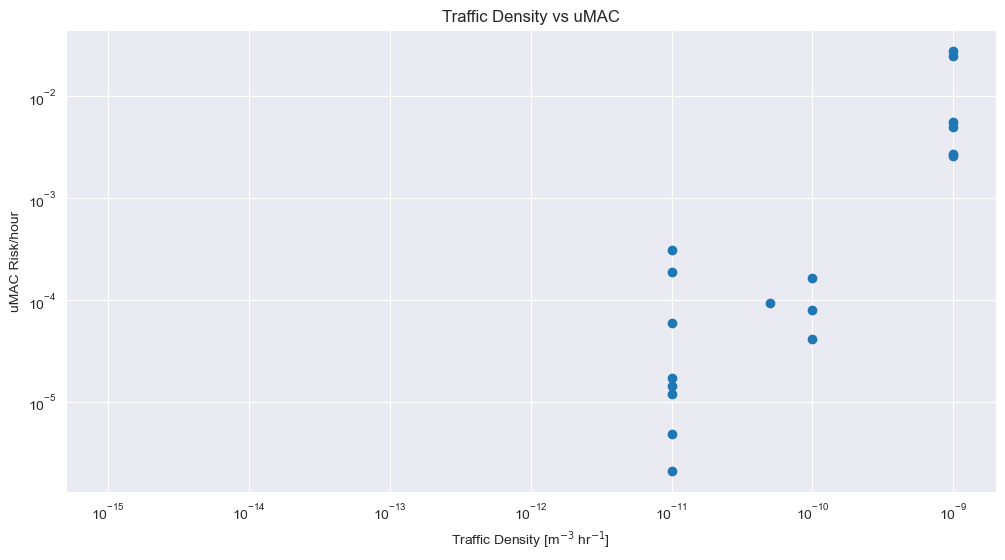

In [132]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df['traffic_density'], res_df['uMAC_per_hour'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Traffic Density vs uMAC')
ax.set_xlabel("Traffic Density [m$^{-3}$ hr$^{-1}$]")
ax.set_ylabel("uMAC Risk/hour")